In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier 
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics
from sklearn.metrics import classification_report
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

# Tree Visualisation
from sklearn.tree import export_graphviz
from six import StringIO
from IPython.display import Image
import pydotplus
import graphviz

import joblib
import shap
shap.initjs()


# Display all columns and rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
df = pd.read_pickle('./data/processed/alzheimers_prediction_dataset.pkl')
X, y = df.drop(columns=['Alzheimer’s Diagnosis']), df["Alzheimer’s Diagnosis"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=8) # random_state for reproducibility 

display(X.head())
display(y.value_counts())


,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,Cholesterol Level,Family History of Alzheimer’s,Cognitive Test Score,Depression Level,Sleep Quality,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,is_former_smoker,is_retired,is_widowed
0,90,1,1,33.0,2,0,2,0,0,0,0,90,1,1,3,3,0,0,0,1,2,3,1,0,1,0
1,72,1,7,29.9,2,0,1,0,0,0,0,65,1,3,3,2,0,0,0,3,1,3,1,1,0,1
2,86,0,19,22.9,3,1,2,0,1,0,0,43,3,3,2,2,1,0,0,1,2,3,0,0,0,0
3,53,1,17,31.2,1,0,3,1,0,0,0,81,2,2,3,2,0,0,0,3,2,1,0,0,1,0
4,58,0,3,30.0,3,0,1,1,0,0,0,49,3,1,1,3,1,1,0,1,2,3,0,1,0,0


Alzheimer’s Diagnosis
0    43570
1    30713
Name: count, dtype: int64

# Logistic Regression

In [4]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=8, solver='lbfgs', max_iter=500) #, max_iter=500

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

[0 1]
Accuracy: 0.7051894729757017


Text(0.5, 427.9555555555555, 'Predicted label')

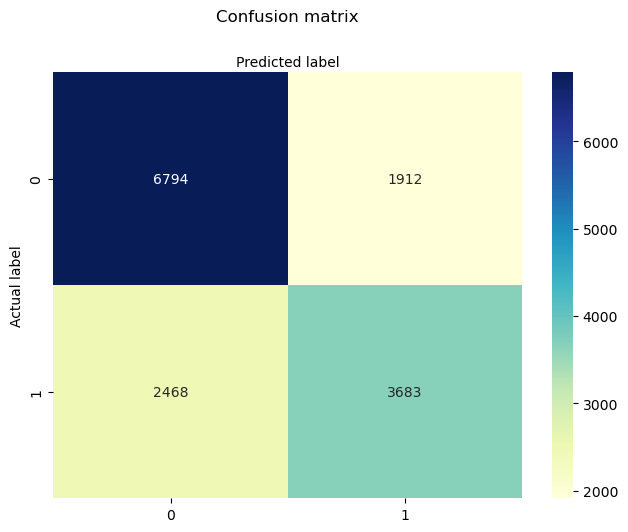

In [5]:
print(y_test.unique())
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [6]:
target_names = ['without Alzheimers', 'with Alzheimers']
print(classification_report(y_test, y_pred, target_names=target_names))

                    precision    recall  f1-score   support

without Alzheimers       0.73      0.78      0.76      8706
   with Alzheimers       0.66      0.60      0.63      6151

          accuracy                           0.71     14857
         macro avg       0.70      0.69      0.69     14857
      weighted avg       0.70      0.71      0.70     14857



[[ 8.14333712e-02  2.70673287e-03 -9.67910456e-04 -3.93716837e-05
   6.50569266e-03 -1.43138539e-02  3.95311279e-03 -1.24504756e-03
  -8.70590007e-03 -2.41345006e-02  8.06690974e-01 -1.16453102e-04
  -1.11333397e-03 -7.73697467e-03 -5.17883657e-03 -1.10129677e-02
  -4.40590775e-03  1.56477112e-02  1.25565910e+00  1.44434541e-03
   1.55229777e-02 -1.35193212e-04 -2.36780343e-02 -1.95609253e-02
   1.98727436e-02  1.94225178e-02]]


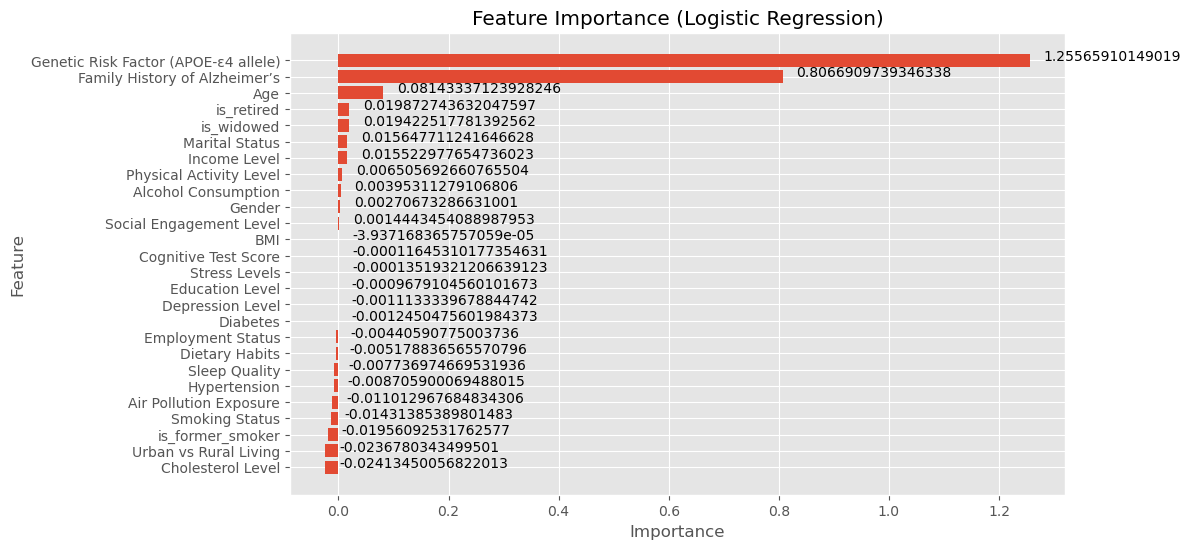

In [15]:
print(logreg.coef_)
logreg.feature_names_in_

# get importance
importance = logreg.coef_[0]

matplotlib.rc('figure', figsize=[5,5])
plt.style.use('ggplot')

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': logreg.feature_names_in_,
    'Importance': importance
})

# Sort feature importance in ascending order
feature_importance = feature_importance.sort_values(by='Importance')

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
for i, value in enumerate(feature_importance["Importance"].to_list()):
    plt.annotate(value, (value, i), textcoords="offset points", xytext=(10,0), ha='left')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importance (Logistic Regression)')
plt.show()

# Decision Tree

In [16]:
# Create Decision Tree classifer object
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train,y_train)

#Predict the response for test dataset
y_pred = clf.predict(X_test)
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6300733660900586


In [93]:
feature_cols = X.columns.to_list()
dot_data = StringIO()
export_graphviz(clf, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True,feature_names = feature_cols,class_names=['0','1'])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png('alzheimers.png')
Image(graph.create_png())

KeyboardInterrupt: 

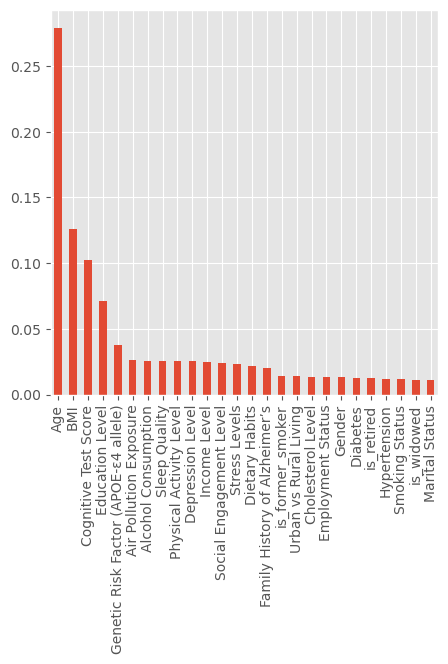

In [17]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

# Random Forest

In [18]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy = metrics.accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 0.7113145318704988


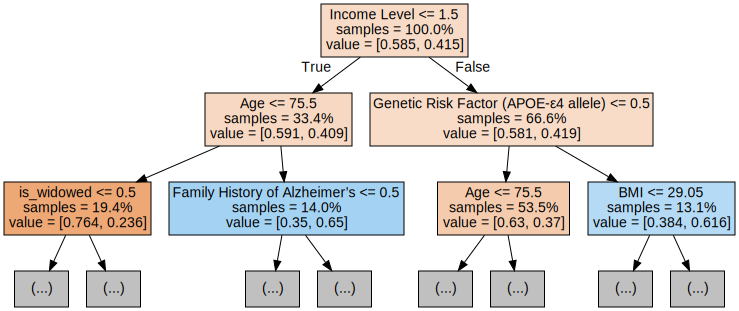

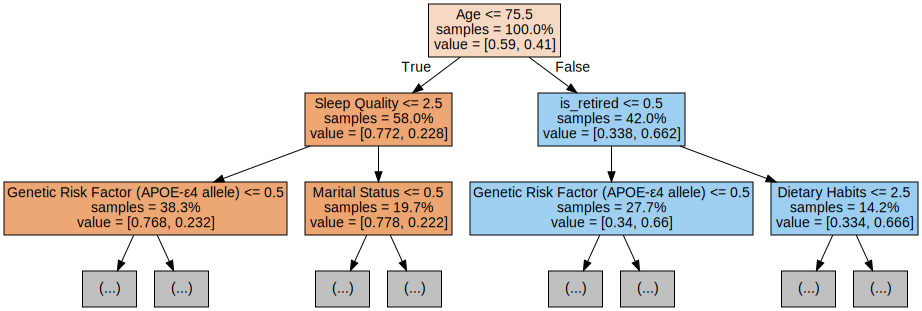

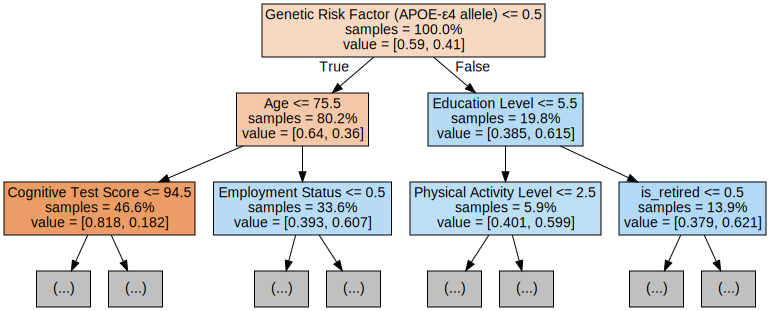

In [55]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

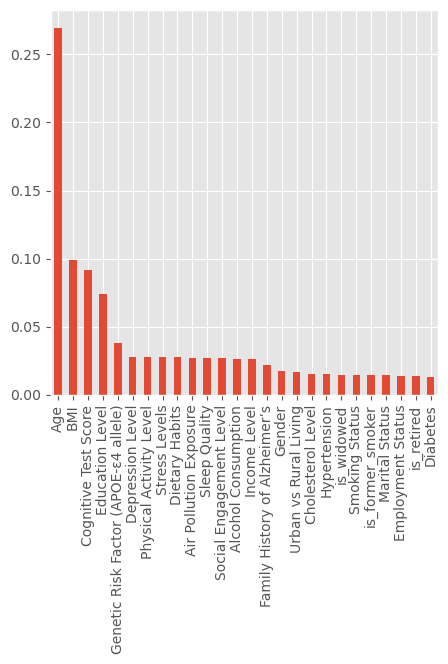

In [19]:
# Create a series containing feature importances from the model and feature names from the training data
feature_importances = pd.Series(rf.feature_importances_, index=X_train.columns).sort_values(ascending=False)

# Plot a simple bar chart
feature_importances.plot.bar();

In [108]:
X_shap = X_test[:1000]
print(X_shap.shape)
X_shap.head()

(1000, 26)


,Age,Gender,Education Level,BMI,Physical Activity Level,Smoking Status,Alcohol Consumption,Diabetes,Hypertension,Cholesterol Level,Family History of Alzheimer’s,Cognitive Test Score,Depression Level,Sleep Quality,Dietary Habits,Air Pollution Exposure,Employment Status,Marital Status,Genetic Risk Factor (APOE-ε4 allele),Social Engagement Level,Income Level,Stress Levels,Urban vs Rural Living,is_former_smoker,is_retired,is_widowed
68930,51,0,8,26.2,1,0,1,0,1,0,0,30,1,2,2,1,0,0,0,3,2,3,0,0,0,0
47936,88,0,16,23.1,1,1,3,0,0,0,1,60,3,3,3,1,1,0,1,2,2,2,1,0,0,1
43141,83,1,0,27.0,2,0,2,1,0,1,0,95,2,2,1,2,0,0,0,3,1,3,1,0,0,0
22399,56,1,0,34.1,1,0,2,0,0,0,0,90,3,3,1,1,0,1,0,3,2,1,1,1,1,0
43289,88,1,12,23.4,1,0,1,0,0,0,0,65,3,2,2,1,0,0,0,1,3,1,1,0,0,1


In [111]:
X100 = shap.utils.sample(X_test, 1000)
explainer = shap.Explainer(rf, X100)
shap_explainer = explainer(X100, check_additivity=False)
shap_values = explainer.shap_values(X100, check_additivity=False)

100%|===================| 1999/2000 [06:50<00:00]        

In [112]:
shap_explainer.shape

(1000, 26, 2)

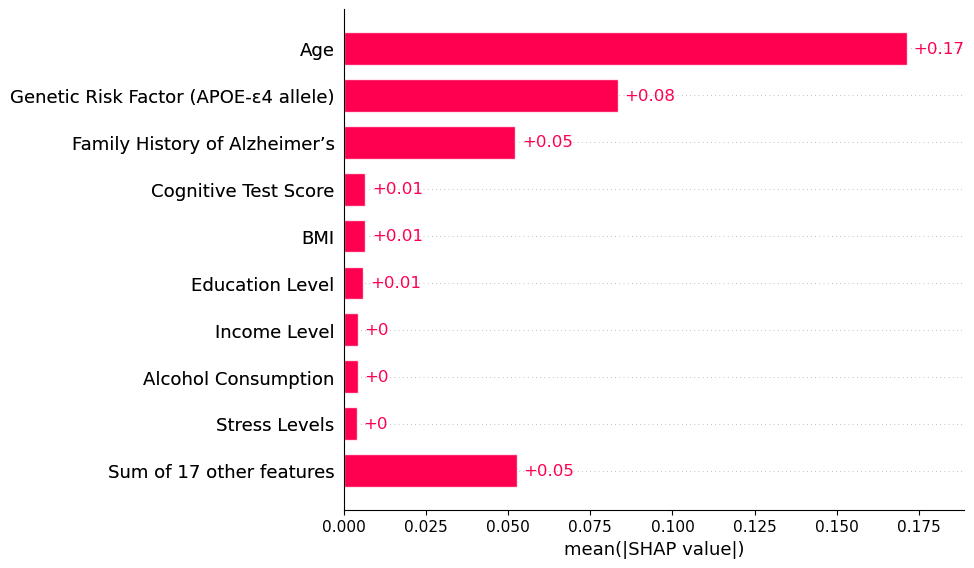

In [115]:
shap.plots.bar(shap_explainer[:,:,0])

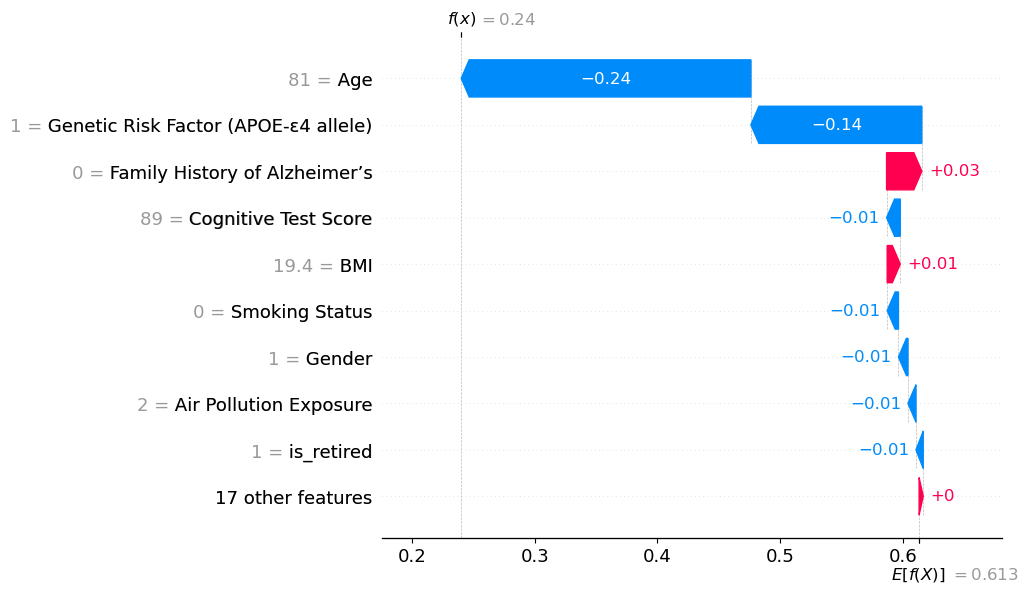

In [120]:
shap.plots.waterfall(shap_explainer[0,:,0])

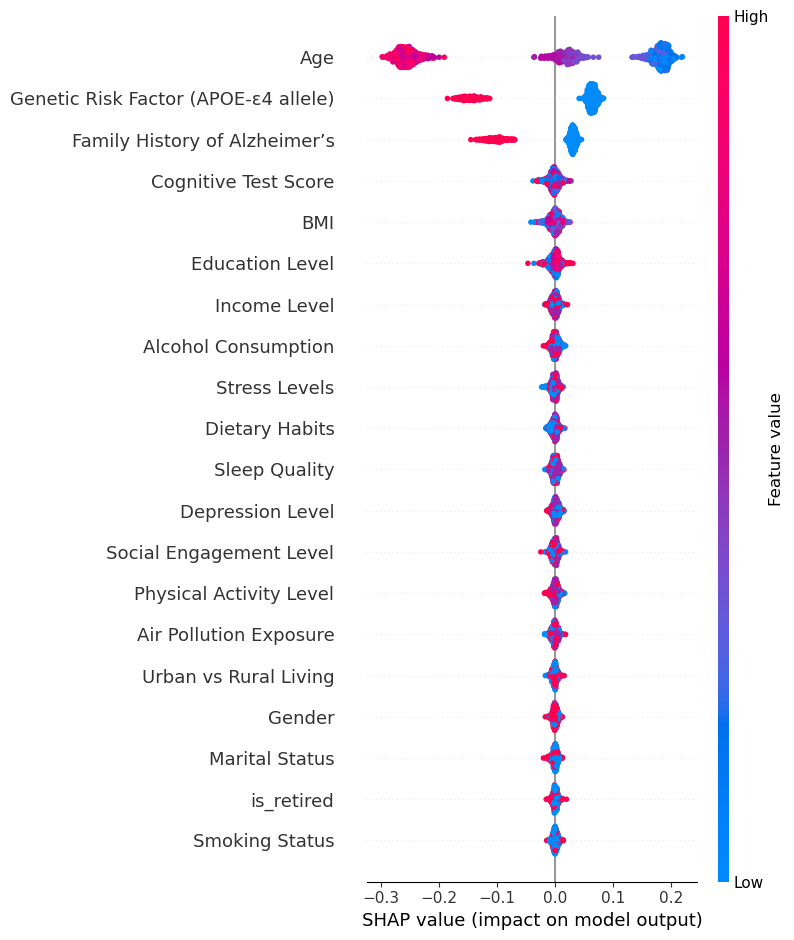

In [125]:
shap.summary_plot(shap_values[:,:,0], X100.astype("float"))


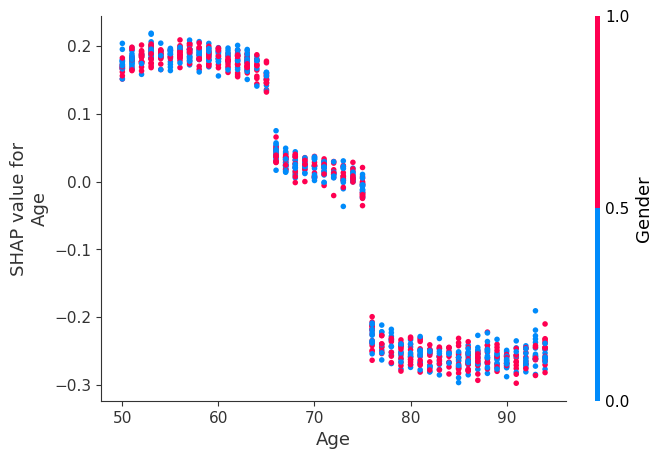

In [130]:
shap.dependence_plot("Age", shap_values[:,:,0], X100, interaction_index="Gender")

In [162]:

X100.iloc[0, :]

Age                                     81.0
Gender                                   1.0
Education Level                         17.0
BMI                                     19.4
Physical Activity Level                  1.0
Smoking Status                           0.0
Alcohol Consumption                      2.0
Diabetes                                 0.0
Hypertension                             0.0
Cholesterol Level                        0.0
Family History of Alzheimer’s            0.0
Cognitive Test Score                    89.0
Depression Level                         1.0
Sleep Quality                            1.0
Dietary Habits                           1.0
Air Pollution Exposure                   2.0
Employment Status                        0.0
Marital Status                           1.0
Genetic Risk Factor (APOE-ε4 allele)     1.0
Social Engagement Level                  2.0
Income Level                             2.0
Stress Levels                            1.0
Urban vs R

In [177]:
y_pred_test = rf.predict(np.expand_dims(X100.iloc[0, :], axis=0))
print(y_pred_test)

[1]


c:\Users\gansh\miniconda3\envs\xai\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


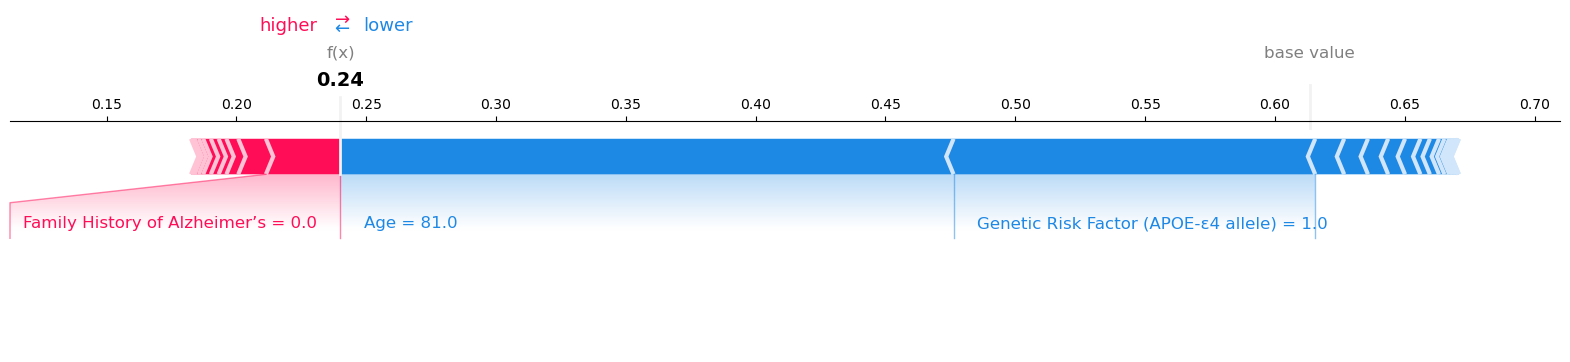

In [161]:
shap.plots.force(explainer.expected_value[0], shap_values[0,:,0], X100.iloc[0, :], matplotlib = True)

In [179]:
shap.plots.force(explainer.expected_value[0], shap_values[:100,:,0], X100.iloc[:100, :])

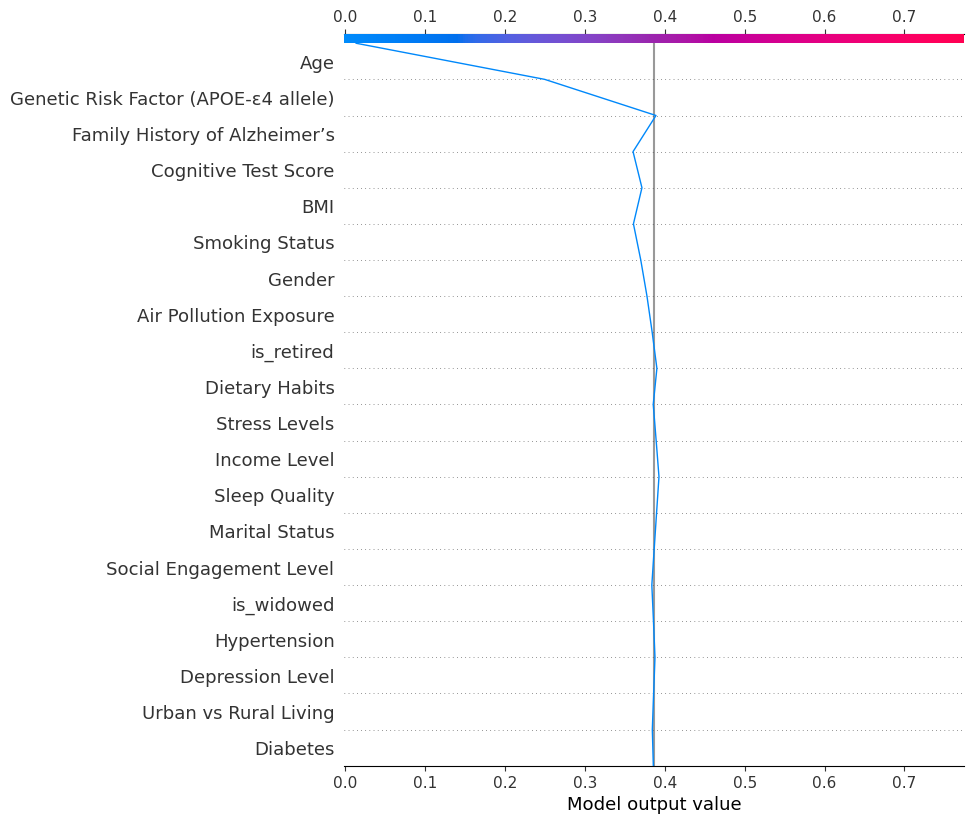

In [183]:
shap.decision_plot(explainer.expected_value[1], shap_values[0,:,0], X100.columns)

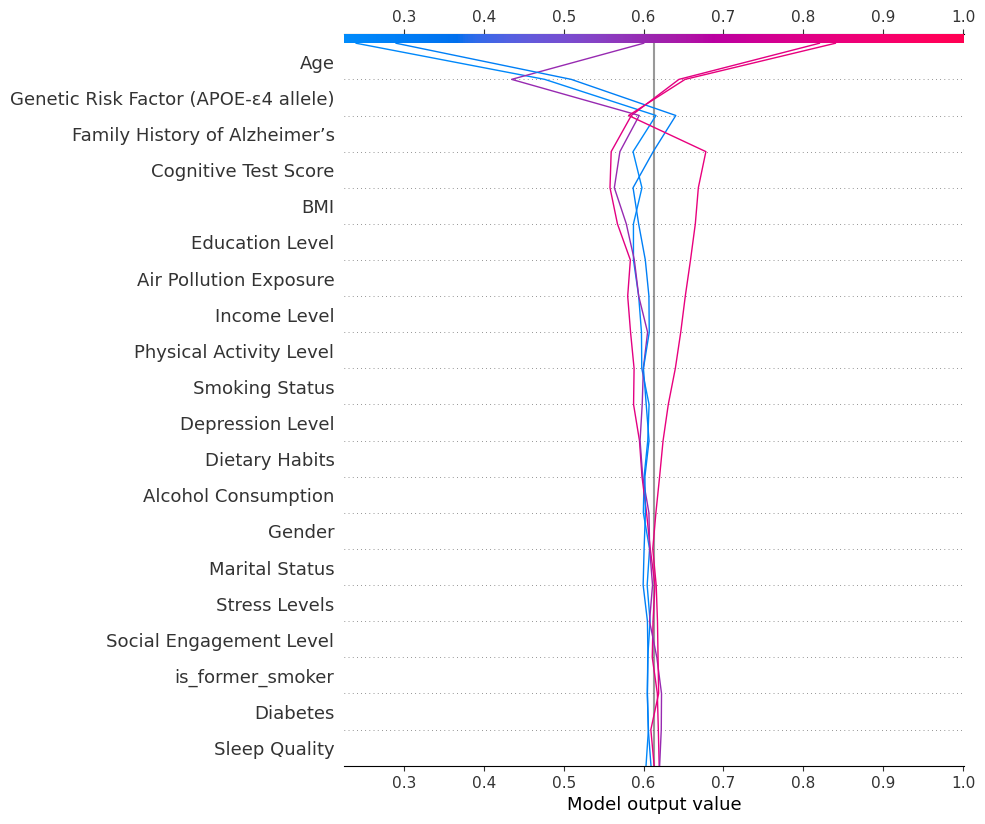

In [188]:
shap.decision_plot(explainer.expected_value[0], shap_values[:5,:,0], X100.columns)

In [192]:
shap_explainer[:100,0,0].shape

(100,)

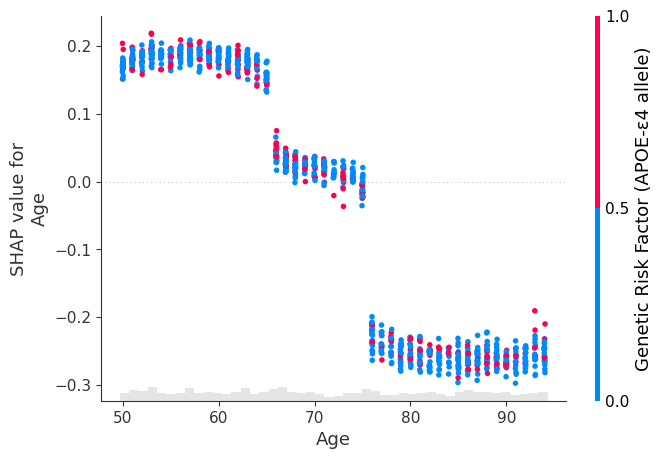

In [196]:
shap.plots.scatter(shap_explainer[:,0,0], color=shap_explainer[:,:,0])

# XGBoost

# Neural Network (Simple)